# 比赛传送门： [常规赛：遥感影像地块分割](https://aistudio.baidu.com/aistudio/competition/detail/63/0/introduction)

# 一、准备工作

In [ ]:
#安装PaddleSeg
!git clone https://gitee.com/paddlepaddle/PaddleSeg.git work/PaddleSeg

Cloning into 'work/PaddleSeg'...
remote: Enumerating objects: 81, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 15118 (delta 26), reused 78 (delta 25), pack-reused 15037
Receiving objects: 100% (15118/15118), 339.00 MiB | 13.11 MiB/s, done.
Resolving deltas: 100% (9890/9890), done.
Checking connectivity... done.


In [1]:
#解压数据集
!unzip -q data/data77571/img_test.zip -d data
!unzip -q data/data77571/train_and_label.zip -d data
!rm -rf data/__MACOSX

In [2]:
#导入所需库
import os
import cv2
import tqdm
import numpy as np
import matplotlib.pyplot as plt

100%|██████████| 66652/66652 [00:40<00:00, 1656.42it/s]


[0.2852427534057493, 0.4050741163055872, 0.30788273420152434, 0.2349066794694833]


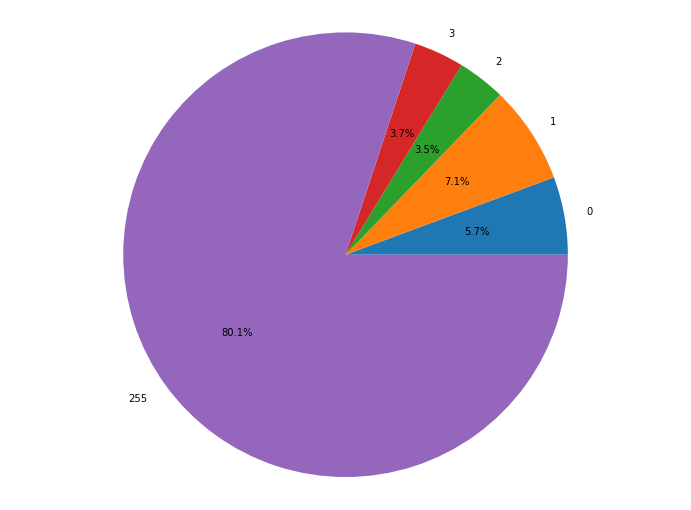

In [3]:
#数据集分析
classes = [0, 1, 2, 3, 255]
all_clasnum = {clas : 0 for clas in classes}
imgsbigger1 = {clas : 0 for clas in classes}
imgs_root = 'data/lab_train'
imgs_name = os.listdir(imgs_root)
img_nums = len(imgs_name)
for img_name in tqdm.tqdm(imgs_name):
    temp_clasnum = {clas : 0 for clas in classes}
    img_path = os.path.join(imgs_root, img_name)
    img_label = cv2.imread(img_path)
    img_label = img_label[:, : ,0]
    for clas in classes:
        clasnum = np.count_nonzero(img_label == clas)
        all_clasnum[clas] += clasnum
        temp_clasnum[clas] += clasnum
    temp_clas_proportion = [temp_clasnum[clas] / (img_label.shape[0] * img_label.shape[1]) for clas in classes]
    if temp_clas_proportion[0] > 0.01:
        imgsbigger1[0] += 1
    if temp_clas_proportion[1] > 0.01:
        imgsbigger1[1] += 1
    if temp_clas_proportion[2] > 0.01:
        imgsbigger1[2] += 1
    if temp_clas_proportion[3] > 0.01:
        imgsbigger1[3] += 1
area = [all_clasnum[clas] for clas in classes]
proportionbigger1 = [imgsbigger1[clas] / img_nums for clas in classes]
print(proportionbigger1[0:4])
plt.figure(figsize=(12,9))
plt.pie(area,labels=classes,autopct='%1.1f%%')
plt.axis('equal')
plt.show()

In [4]:
#数据集划分
imgs_name = os.listdir('data/img_train')
ratio = 0.9
cutline = int(len(imgs_name)*ratio)
train_list_origin = imgs_name[:cutline]
val_list_origin = imgs_name[cutline:]

#生成trainlist
with open('work/Configration/train_list.txt','w') as f:
    for i in range(len(train_list_origin)):
        train_img_name = 'img_train/' + train_list_origin[i]
        train_lab_name = 'lab_train/' + train_list_origin[i].split('.')[0] + '.png'
        f.write(train_img_name + ' ' + train_lab_name + '\n')

#生成vallist
with open('work/Configration/val_list.txt','w') as f:
    for i in range(len(val_list_origin)):
        val_img_name = 'img_train/' + val_list_origin[i]
        val_lab_name = 'lab_train/' + val_list_origin[i].split('.')[0] + '.png'
        f.write(val_img_name + ' ' + val_lab_name + '\n')

In [ ]:
#开始训练
!python work/PaddleSeg/train.py \
       --config work/Configration/Segformer_B5_Test.yaml \
       --do_eval \
       --save_interval 5000 \
       --save_dir work/output

In [ ]:
#恢复训练
!python work/PaddleSeg/train.py \
       --config work/Configration/Segformer_B5_Test.yaml \
       --resume_model work/output/iter_10000 \
       --do_eval \
       --use_vdl \
       --save_interval 5000 \
       --save_dir work/output

In [ ]:
#模型预测
!python work/PaddleSeg/predict.py \
       --config work/Configration/Segformer_B5_Test.yaml \
       --model_path work/output/best_model/model.pdparams \
       --image_path data/img_testA \
       --save_dir work/result

In [ ]:
#结果打包
!zip -q -r -j result.zip work/result/result_prediction